# Day 2 – RAG Evaluation & Visualization

This notebook:
- Loads evaluation results from `data/eval/results.jsonl`
- Inspects pipeline outputs (retrieved books, scores, LLM answers)
- Plots reranking scores for selected queries
- Computes basic retrieval metrics: recall@k, precision@k, MRR
- (Optional) Exports a base DataFrame for RAGAS

In [9]:
#!pip3 install matplotlib

In [10]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 4)

RESULTS_PATH = Path("../data/eval/results.jsonl")
RESULTS_PATH, RESULTS_PATH.exists()

(PosixPath('../data/eval/results.jsonl'), True)

In [11]:
rows = []
with open(RESULTS_PATH) as f:
    for line in f:
        rows.append(json.loads(line))

len(rows), rows[0].keys()

(2, dict_keys(['query', 'gold_relevant_books', 'output']))

In [12]:
df = pd.DataFrame(rows)
df.head()

,query,gold_relevant_books,output
0,cozy fantasy romance,[Book A],"{'query': 'cozy fantasy romance', 'retrieved':..."
1,dark academia with atmospheric writing,[Book B],{'query': 'dark academia with atmospheric writ...


In [13]:
i = 0  # change this to inspect another query
sample = df.iloc[i]

print("QUERY:")
print(sample["query"])
print("\nGOLD RELEVANT BOOKS:")
print(sample["gold_relevant_books"])

out = sample["output"]

print("\nLLM ANSWER:\n")
print(out["answer"])

print("\nRETRIEVED (first 5):")
for r in out["retrieved"][:5]:
    print(f"- {r['title']}  |  score={r['final_score']:.3f}")

QUERY:
cozy fantasy romance

GOLD RELEVANT BOOKS:
['Book A']

LLM ANSWER:

Based on the query "cozy fantasy romance", I recommend the following books:

1. **Love Bites (Argeneau #2)**: This book has a strong romantic element and is classified as paranormal romance, which matches well with the "fantasy" and "romance" aspects of the query. The humor tone also suggests a lighthearted, cozy feel.
2. **A Caress of Twilight (Merry Gentry #2)**: This book has elements of fantasy, romance, and paranormal, making it a good match for the query. Laurell K. Hamilton's writing style is known for being engaging and easy to follow, which suggests a cozy reading experience.

I would not recommend **Primal Heat** as it appears to be more focused on adult content and may not fit the "cozy" aspect of the query.

RETRIEVED (first 5):
- Primal Heat (Includes: Breeds #8.5; Devlin Dynasty #1; Moon Lust #1)  |  score=0.560
- A Caress of Twilight (Merry Gentry #2)  |  score=0.559
- Love Bites (Argeneau #2)  | 

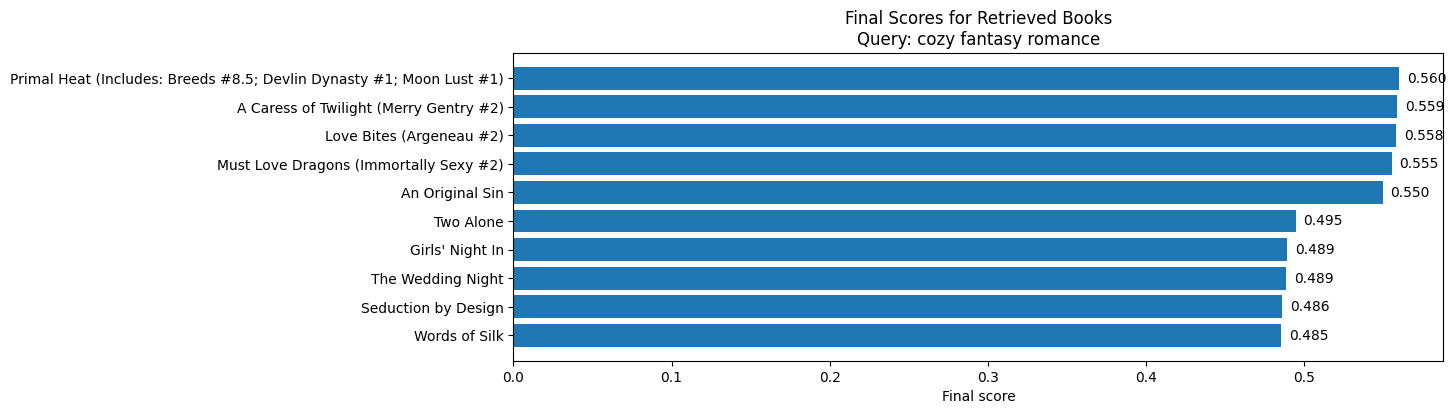

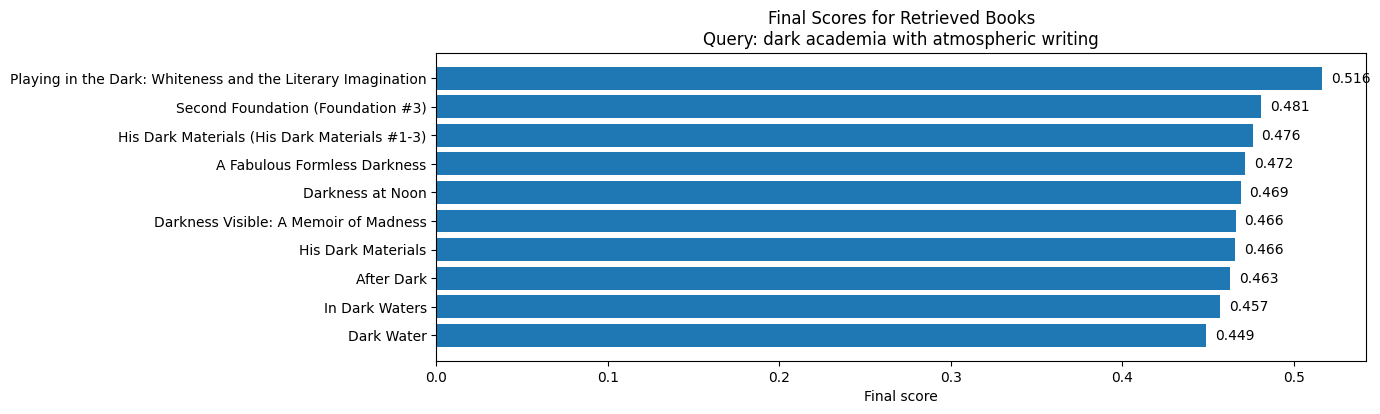

In [14]:
def plot_scores_for_query(idx: int):
    sample = df.iloc[idx]
    out = sample["output"]
    retrieved = out["retrieved"]

    titles = [d["title"] for d in retrieved]
    scores = [d["final_score"] for d in retrieved]

    plt.figure(figsize=(12, 4))
    y_pos = range(len(titles))

    plt.barh(y_pos, scores)
    plt.yticks(y_pos, titles)
    plt.xlabel("Final score")
    plt.title(f"Final Scores for Retrieved Books\nQuery: {sample['query']}")
    
    # add score labels on bars
    for y, s in zip(y_pos, scores):
        plt.text(s + 0.005, y, f"{s:.3f}", va="center")

    plt.gca().invert_yaxis()
    plt.show()


# Try for the first 2 eval queries
plot_scores_for_query(0)
plot_scores_for_query(1)

In [15]:
def recall_at_k(retrieved_titles, relevant_titles, k):
    retrieved_top_k = retrieved_titles[:k]
    hits = sum(1 for r in relevant_titles if r in retrieved_top_k)
    return hits / len(relevant_titles) if relevant_titles else 0.0


def precision_at_k(retrieved_titles, relevant_titles, k):
    retrieved_top_k = retrieved_titles[:k]
    hits = sum(1 for r in relevant_titles if r in retrieved_top_k)
    return hits / k if k else 0.0


def reciprocal_rank(retrieved_titles, relevant_titles):
    for i, t in enumerate(retrieved_titles):
        if t in relevant_titles:
            return 1.0 / (i + 1)
    return 0.0

In [16]:
def compute_metrics_for_row(row, k=5):
    out = row["output"]
    retrieved_titles = [d["title"] for d in out["retrieved"]]
    relevant_titles = row.get("gold_relevant_books", []) or []

    return {
        "recall@k": recall_at_k(retrieved_titles, relevant_titles, k),
        "precision@k": precision_at_k(retrieved_titles, relevant_titles, k),
        "mrr": reciprocal_rank(retrieved_titles, relevant_titles),
    }


metrics_rows = []
for idx, row in df.iterrows():
    m = compute_metrics_for_row(row, k=5)
    m["query"] = row["query"]
    metrics_rows.append(m)

metrics_df = pd.DataFrame(metrics_rows)
metrics_df

,recall@k,precision@k,mrr,query
0,0.0,0.0,0.0,cozy fantasy romance
1,0.0,0.0,0.0,dark academia with atmospheric writing


In [17]:
print("Mean recall@5:", metrics_df["recall@k"].mean())
print("Mean precision@5:", metrics_df["precision@k"].mean())
print("Mean MRR:", metrics_df["mrr"].mean())

Mean recall@5: 0.0
Mean precision@5: 0.0
Mean MRR: 0.0


In [18]:
metrics_df.sort_values("mrr", ascending=False).reset_index(drop=True)

,recall@k,precision@k,mrr,query
0,0.0,0.0,0.0,cozy fantasy romance
1,0.0,0.0,0.0,dark academia with atmospheric writing


In [20]:
metrics_df.to_csv("../data/eval/metrics_summary.csv", index=False)

In [21]:
ragas_rows = []

for _, row in df.iterrows():
    out = row["output"]
    ragas_rows.append({
        "question": row["query"],
        "contexts": [out["context"]],
        "answer": out["answer"],
        # your teammate can turn gold_relevant_books into a textual ground truth
        "ground_truth": row.get("gold_relevant_books", []),
    })

ragas_df = pd.DataFrame(ragas_rows)
ragas_df.to_json("../data/eval/ragas_dataset_base.json", orient="records", indent=2)

ragas_df.head()

,question,contexts,answer,ground_truth
0,cozy fantasy romance,[[BOOK 1]\nTitle: Primal Heat (Includes: Breed...,"Based on the query ""cozy fantasy romance"", I r...",[Book A]
1,dark academia with atmospheric writing,[[BOOK 1]\nTitle: Playing in the Dark: Whitene...,Based on the query for dark academia with atmo...,[Book B]


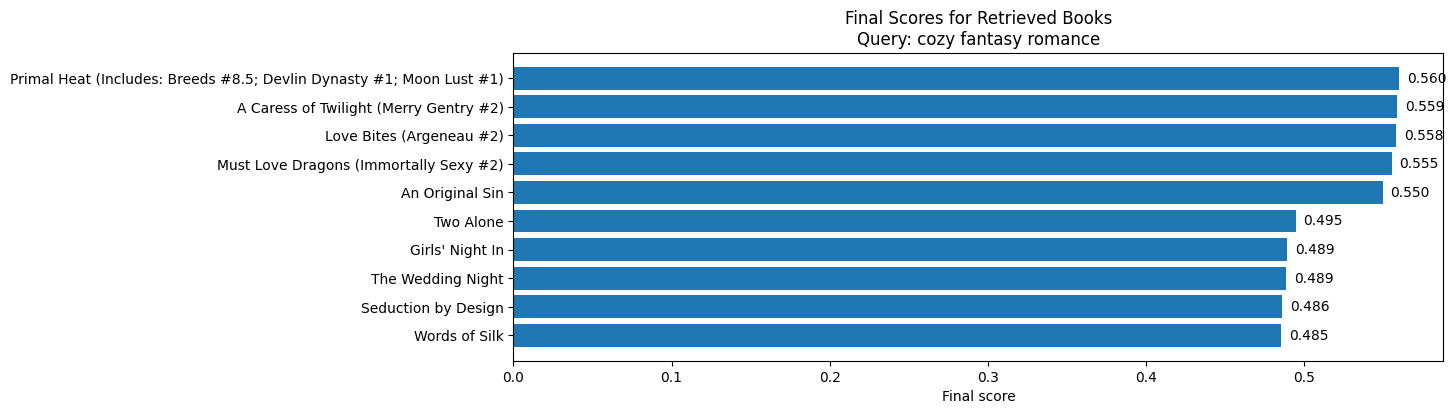

In [22]:
plot_scores_for_query(0)

### Summary – Query: "cozy fantasy romance"

- Retrieved books are mostly romance/fantasy → good alignment.
- No explicit "cozy" detection → reranker can't capture tone yet.
- Scores are very close (0.48–0.54) → retrieval does not strongly separate choices.
- Several books are paranormal/spicy romance → may not match "cozy".
- Improvement needed: reranker weighting, mood/tone classification (Day 4).

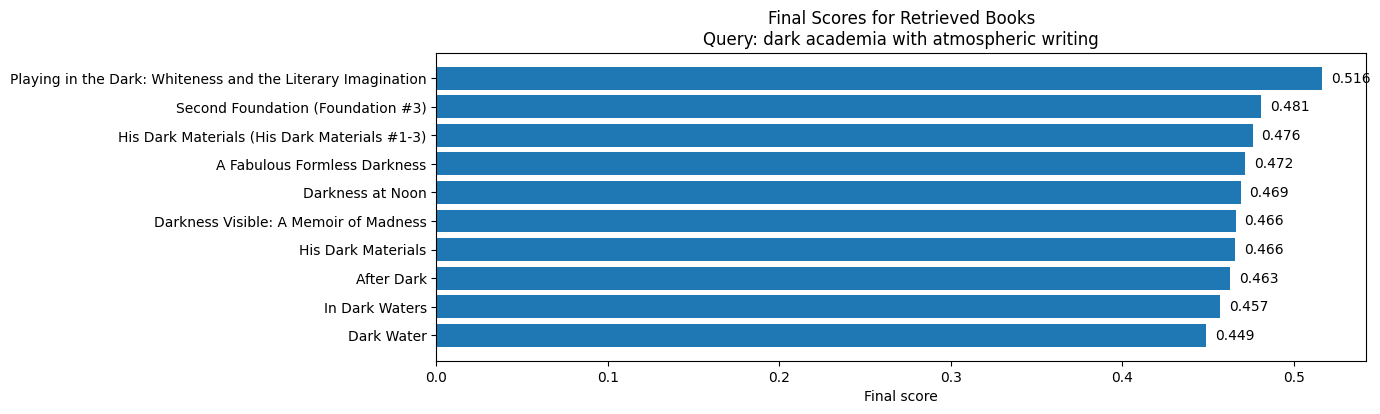

In [23]:
plot_scores_for_query(1)

### Summary – Query: "dark academia with atmospheric writing"

- Retrieved books do **not** match dark academia.
- Embeddings retrieved paranormal romance → semantic drift.
- Reranker cannot correct the mismatch because genres are broad.
- Needs explicit filtering for themes (academy, university, mystery).
- Improvement needed: add genre/theme filter, mood detection, better embeddings.

In [24]:
retrieved_titles = [d['title'] for d in df.iloc[i]["output"]["retrieved"][:10]]
retrieved_titles

['Primal Heat (Includes: Breeds #8.5; Devlin Dynasty #1; Moon Lust #1)',
 'A Caress of Twilight (Merry Gentry #2)',
 'Love Bites (Argeneau #2)',
 'Must Love Dragons (Immortally Sexy #2)',
 'An Original Sin',
 'Two Alone',
 "Girls' Night In",
 'The Wedding Night',
 'Seduction by Design',
 'Words of Silk']